In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import geopandas
from shapely.geometry import Point
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import r2_score

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df_train = pd.read_csv("data/df_train.csv")
df_test = pd.read_csv("data/df_test.csv")

print(df_train.shape)
print(df_test.shape)

(4077, 10)
(4057, 10)


In [3]:
def visualize_prediction(y_test, y_pred):
    plt.figure(figsize=(12,8))
    plt.scatter(np.arange(len(y_test)),y_test,label = "Ground truth", s=3)
    plt.scatter(np.arange(len(y_test)),y_pred,label = "Prediction", s=3)
    plt.legend()
    plt.title("Ground truth vs OLS prediction")
    plt.xlabel("Index")
    plt.ylabel("Number of Crime")
    plt.show()
    
def evaluate_prediction(y_test,y_pred):
    print("R squared is:",r2_score(y_test, y_pred))
    print("MAE error is:",mean_absolute_error(y_test, y_pred))

# Data Cleaning

In [4]:
# Fill in missing values for median_home_value
print(df_train.isna().sum())
print(df_test.isna().sum())
fill_value =  df_train['median_home_value'].dropna().mean()
df_train['median_home_value'] = df_train['median_home_value'].fillna(fill_value)
df_test['median_home_value'] = df_train['median_home_value'].fillna(fill_value)
print(df_train.isna().sum().sum())
print(df_test.isna().sum().sum())

incident_day_of_week         0
incident_hour                0
zipcode                      0
crime                        0
population                   0
population_density           0
housing_units                0
occupied_housing_units       0
median_home_value          228
median_household_income      0
dtype: int64
incident_day_of_week         0
incident_hour                0
zipcode                      0
crime                        0
population                   0
population_density           0
housing_units                0
occupied_housing_units       0
median_home_value          206
median_household_income      0
dtype: int64
0
0


In [6]:
# Use one-hot encoding for categorical variable
X_train_raw = df_train.drop(columns = ['crime'])
X_test_raw = df_test.drop(columns = ['crime'])
X_train_dummy = pd.get_dummies(X_train_raw, 
                               columns = ['incident_day_of_week','incident_hour','zipcode'], 
                               drop_first = True)
X_test_dummy = pd.get_dummies(X_test_raw, 
                               columns = ['incident_day_of_week','incident_hour','zipcode'], 
                               drop_first = True)

In [7]:
# Standardize the numerical columns.
def standardize(df, cols, df_train):
    scalar = StandardScaler().fit(df_train[cols])
    result = df.copy()
    transformed_cols = scalar.transform(result[cols])
    result = result.drop(cols, 1)
    for i in range(len(cols)): 
        col = cols[i]
        result[col] = transformed_cols[:, i]
    return result
cols = ['population','population_density','housing_units',
        'occupied_housing_units','median_home_value','median_household_income']

X_test_clean = standardize(X_test_dummy,cols,X_train_dummy)
X_train_clean = standardize(X_train_dummy,cols,X_train_dummy)

In [8]:
X_train_clean.describe()

,incident_day_of_week_Monday,incident_day_of_week_Saturday,incident_day_of_week_Sunday,incident_day_of_week_Thursday,incident_day_of_week_Tuesday,incident_day_of_week_Wednesday,incident_hour_1,incident_hour_2,incident_hour_3,incident_hour_4,...,zipcode_94131.0,zipcode_94132.0,zipcode_94134.0,zipcode_94158.0,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
count,4077.000000,4077.000000,4077.000000,4077.000000,4077.000000,4077.000000,4077.000000,4077.000000,4077.000000,4077.000000,...,4077.000000,4077.000000,4077.000000,4077.000000,4.077000e+03,4.077000e+03,4.077000e+03,4.077000e+03,4.077000e+03,4.077000e+03
mean,0.142997,0.142507,0.142261,0.143488,0.142261,0.142507,0.040961,0.040471,0.040226,0.039245,...,0.040471,0.040716,0.041207,0.041207,-2.189402e-17,-1.209073e-16,-1.028257e-16,-6.709810e-17,1.084898e-16,1.938874e-17
std,0.350113,0.349612,0.349361,0.350613,0.349361,0.349612,0.198225,0.197085,0.196512,0.194200,...,0.197085,0.197656,0.198793,0.198793,1.000123e+00,1.000123e+00,1.000123e+00,1.000123e+00,1.000123e+00,1.000123e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.465070e+00,-1.460934e+00,-1.544645e+00,-1.548363e+00,-2.063409e+00,-1.753164e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-8.085297e-01,-7.275339e-01,-7.058379e-01,-6.580558e-01,-4.274324e-01,-7.253716e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.029040e-01,-2.435368e-01,8.150971e-02,2.296114e-02,-6.781954e-02,3.783125e-02
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4.395449e-01,2.712460e-01,5.306488e-01,5.194319e-01,8.312127e-01,4.819585e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.416633e+00,2.404964e+00,2.609779e+00,2.490566e+00,1.411981e+00,2.497331e+00


In [9]:
X_test_clean.describe()

,incident_day_of_week_Monday,incident_day_of_week_Saturday,incident_day_of_week_Sunday,incident_day_of_week_Thursday,incident_day_of_week_Tuesday,incident_day_of_week_Wednesday,incident_hour_1,incident_hour_2,incident_hour_3,incident_hour_4,...,zipcode_94131.0,zipcode_94132.0,zipcode_94134.0,zipcode_94158.0,population,population_density,housing_units,occupied_housing_units,median_home_value,median_household_income
count,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.00000,4057.000000,...,4057.000000,4057.00000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000
mean,0.144195,0.142470,0.141977,0.142963,0.142470,0.143702,0.040917,0.040177,0.04067,0.040424,...,0.040424,0.04067,0.041410,0.041410,0.007367,0.008061,0.008350,0.008272,-0.000355,-0.003468
std,0.351331,0.349574,0.349069,0.350078,0.349574,0.350831,0.198122,0.196399,0.19755,0.196976,...,0.196976,0.19755,0.199261,0.199261,0.997803,0.997121,0.996696,0.996798,1.000227,0.995010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,-1.465070,-1.460934,-1.544645,-1.548363,-2.063409,-1.753164
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,-0.808530,-0.727534,-0.705838,-0.658056,-0.427432,-0.725372
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,-0.102904,-0.243537,0.081510,0.022961,-0.067820,0.037831
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.439545,0.271246,0.530649,0.519432,0.831213,0.481959
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.00000,1.000000,1.000000,2.416633,2.404964,2.609779,2.490566,1.411981,2.497331


In [10]:
# Get y_train and y_test
y_train = df_train['crime'].values
y_test = df_test['crime'].values

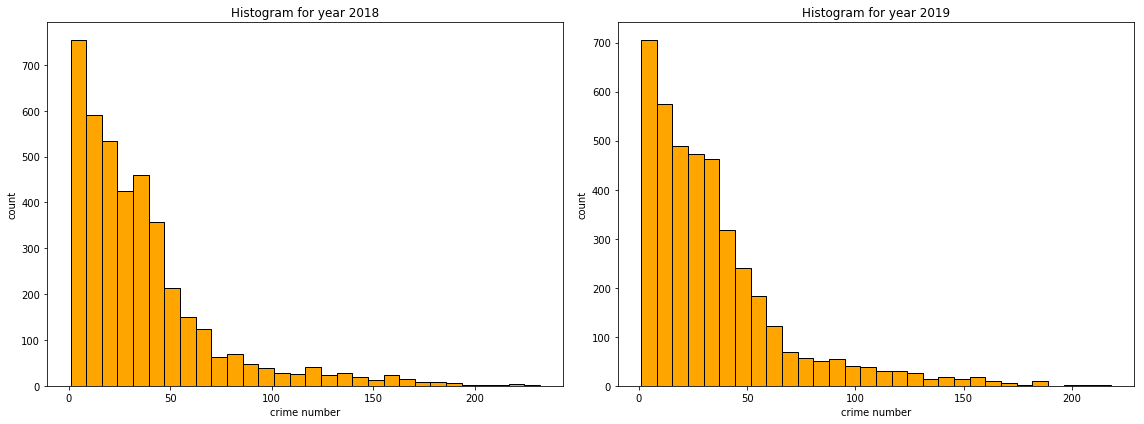

In [11]:
# Visualize crime distribution of 2018 and 2019
fig,ax = plt.subplots(1, 2, figsize=(16,6))

# Draw the plot
ax[0].hist(y_train,color = 'orange', edgecolor = 'black', bins=30)
# Title and labels
ax[0].set_title("Histogram for year 2018")
ax[0].set_xlabel('crime number')
ax[0].set_ylabel('count')
ax[1].hist(y_test,color = 'orange', edgecolor = 'black', bins=30)

# Title and labels
ax[1].set_title('Histogram for year 2019')
ax[1].set_xlabel('crime number')
ax[1].set_ylabel('count')

plt.tight_layout()
plt.show()

## Base Model

In [12]:
zipcode_avg_crime = df_train.groupby('zipcode')['crime'].mean().to_dict()
base_preds = df_test['zipcode'].map(zipcode_avg_crime).values
evaluate_prediction(y_test,base_preds)

R squared is: 0.6212446013653323
MAE error is: 13.73941975080108


## Linear Regression

In [13]:
# Check colinearity
X_numerical = X_train_clean[cols]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]
vif["features"] = X_numerical.columns
vif.round(1)

,VIF Factor,features
0,23.5,population
1,2.8,population_density
2,2065.6,housing_units
3,2363.2,occupied_housing_units
4,2.3,median_home_value
5,1.4,median_household_income


In [14]:
# Dropout columns with huge VIF Factor
X_train_final = X_train_clean.drop(columns=['population','housing_units','occupied_housing_units'])
X_test_final = X_test_clean.drop(columns=['population','housing_units','occupied_housing_units'])

In [15]:
import statsmodels.api as sm
linear_regression = sm.OLS(y_train, X_train_final)
results = linear_regression.fit()
y_pred_lr = results.predict(X_test_final)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     329.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:53:57   Log-Likelihood:                -16813.
No. Observations:                4077   AIC:                         3.373e+04
Df Residuals:                    4023   BIC:                         3.407e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
incident_day_of_week_Monday       -2.4292      0.880     -2.760      0.006      -4.155      -0.704
incident_day_of_week_Saturday     -1.9709      0.881     -2.237      0.025      -3.698      -0.244
incident_day_of_week_Sunday       -5.2593      0.881     -5.967      0.000      -6.987      -3.531
incident_day_of_week_Thursday     -2.4628      0.879     -2.800      0.005      -4.187      -0.739
incident_day_of_week_Tuesday      -2.7397      0.881     -3.108      0.002      -4.468      -1.012
incident_day_of_week_Wednesday    -1.2457      0.881     -1.414      0.157      -2.973       0.481
incident_hour_1                  -22.3029      1.636    -13.636      0.000     -25.509     -19.096
incident_hour_2                  -26.5083      1.641    -16.156      0.000     -29.725     -23.292
incident_hour_3                  -31.2121      1.644    -18.991      0.000     -34.434     -27.990
incident_hour_4                  -34.0973      1.654    -20.614      0.000     -37.340     -30.854
incident_hour_5                  -33.6615      1.635    -20.582      0.000     -36.868     -30.455
incident_hour_6                  -30.4276      1.635    -18.606      0.000     -33.634     -27.221
incident_hour_7                  -22.4461      1.638    -13.703      0.000     -25.658     -19.235
incident_hour_8                  -12.5331      1.626     -7.710      0.000     -15.720      -9.346
incident_hour_9                   -9.1604      1.623     -5.644      0.000     -12.343      -5.978
incident_hour_10                  -4.6911      1.626     -2.886      0.004      -7.878      -1.504
incident_hour_11                  -1.6791      1.626     -1.033      0.302      -4.866       1.508
incident_hour_12                  10.9065      1.621      6.729      0.000       7.729      14.084
incident_hour_13                   1.5489      1.618      0.957      0.339      -1.624       4.722
incident_hour_14                   0.7746      1.618      0.479      0.632      -2.398       3.948
incident_hour_15                   3.3873      1.623      2.087      0.037       0.205       6.570
incident_hour_16                   5.0071      1.621      3.089      0.002       1.829       8.185
incident_hour_17                   7.7942      1.623      4.802      0.000       4.612      10.976
incident_hour_18                   9.0690      1.618      5.603      0.000       5.896      12.242
incident_hour_19                   5.8016      1.623      3.574      0.000       2.619       8.984
incident_hour_20                   1.5146      1.628      0.930      0.352      -1.677       4.707
incident_hour_21                  -4.9483      1.628     -3.040      0.002      -8.140      -1.757
incident_hour_22                  -7.1556      1.628     -4.395      0.000     -10.348      -3.964
incident_hour_

R squared is: 0.27598647794801445
MAE error is: 22.077877717597634


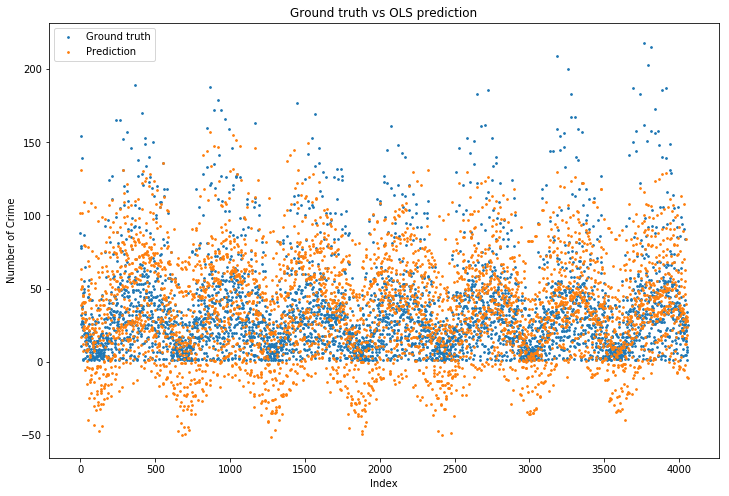

In [16]:
# Evaluate model performance
evaluate_prediction(y_test, y_pred_lr)
visualize_prediction(y_test, y_pred_lr)

## Regularization


### LASSO Regression

The best alpha for lasso is 0.01
R squared is: 0.7645509355114531
MAE error is: 11.518894920165826


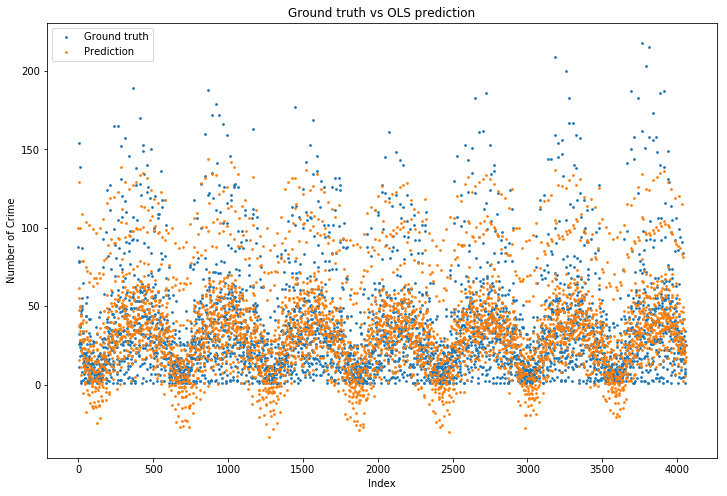

In [17]:
lam = [0.001,0.01,0.1,1,10]

# Fit the CV LASSO model
model_lasso = LassoCV(alphas = lam, max_iter = 100000, fit_intercept = True, cv = 5)
model_lasso.fit(X_train_final,y_train)
print("The best alpha for lasso is %s" %model_lasso.alpha_)
y_pred_lasso = model_lasso.predict(X_test_final)

# Evaluate model performance
evaluate_prediction(y_test, y_pred_lasso)
visualize_prediction(y_test, y_pred_lasso)

### Ridge Regression

The best alpha for ridge is 1.0
R squared is: 0.7121914832070066
MAE error is: 13.175000701673246


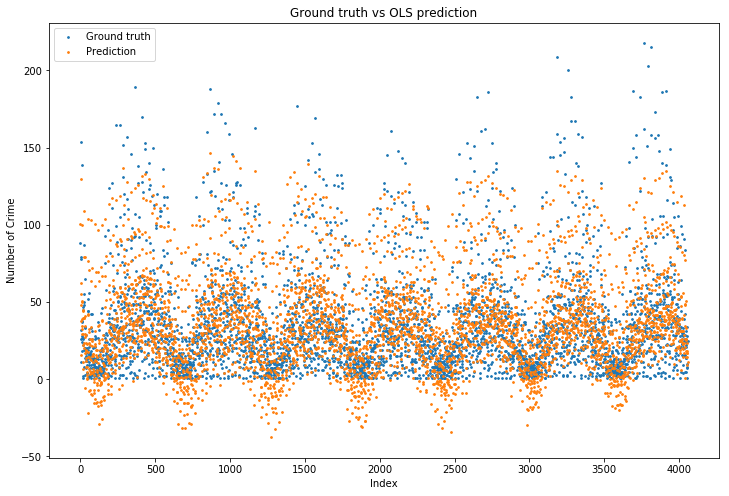

In [18]:
# Fit the Ridge model
model_ridge = RidgeCV(alphas = lam,fit_intercept = True,cv = 5)
model_ridge.fit(X_train_final,y_train)
print("The best alpha for ridge is %s" %model_ridge.alpha_)
y_pred_ridge = model_ridge.predict(X_test_final)

# Evaluate model performance
evaluate_prediction(y_test, y_pred_ridge)
visualize_prediction(y_test, y_pred_ridge)

## Random Forest

R squared is: 0.8891692681926214
MAE error is: 7.664545723440966


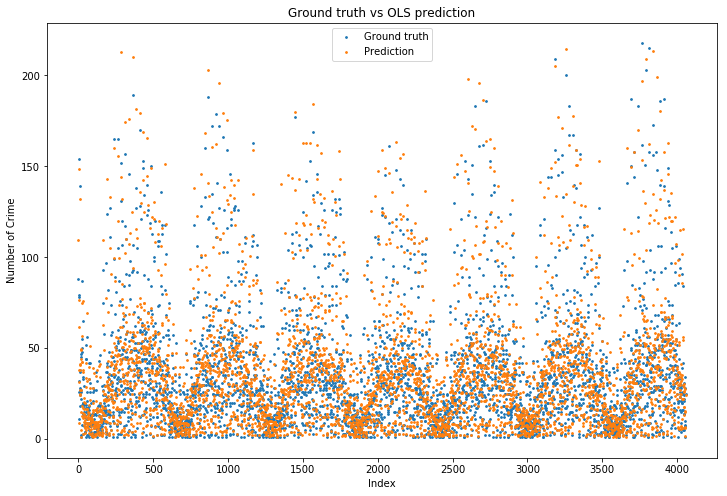

In [19]:
rf = RandomForestRegressor(n_estimators=500, n_jobs=-1).fit(X_train_clean,y_train)
y_pred_rf = rf.predict(X_test_clean)

# Evaluate model performance
evaluate_prediction(y_test, y_pred_rf)
visualize_prediction(y_test, y_pred_rf)

In [20]:
list(zip(X_train_final.columns, rf.feature_importances_))[:10]

[('incident_day_of_week_Monday', 0.005536218432026928),
 ('incident_day_of_week_Saturday', 0.008526633484889511),
 ('incident_day_of_week_Sunday', 0.011883080127550792),
 ('incident_day_of_week_Thursday', 0.005470707296763398),
 ('incident_day_of_week_Tuesday', 0.005803872310574518),
 ('incident_day_of_week_Wednesday', 0.006369234749833006),
 ('incident_hour_1', 0.02226111804048625),
 ('incident_hour_2', 0.027527253774026598),
 ('incident_hour_3', 0.03379689576572439),
 ('incident_hour_4', 0.03770885214150385)]

## KNN

R squared is: 0.6090241673519854
MAE error is: 13.30576780872566


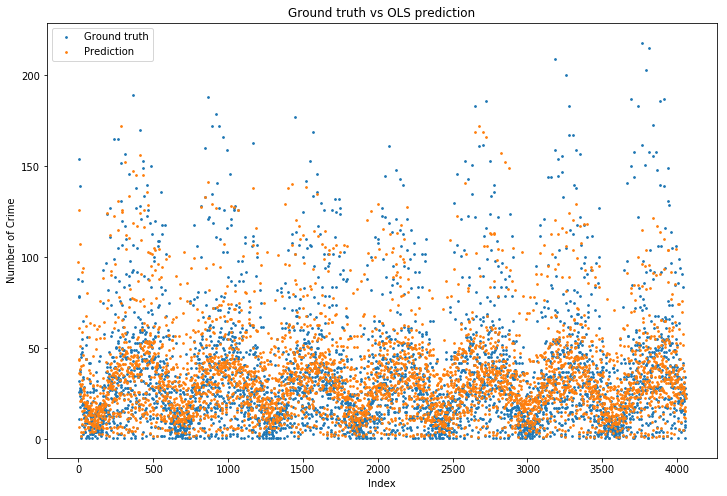

In [22]:
KNN = KNeighborsRegressor(n_neighbors=10)
KNN.fit(X_train_final,y_train)
y_pred_KNN = KNN.predict(X_test_final)

# Evaluate model performance
evaluate_prediction(y_test, y_pred_KNN)
visualize_prediction(y_test, y_pred_KNN)

## Neural Network

In [26]:
from tensorflow.keras import layers

validation_split = 0.2
epochs = 50
optimizer = tf.keras.optimizers.RMSprop(5e-4)
model = tf.keras.models.Sequential()
model.add(layers.Dense(units=100, activation='relu', input_dim = X_train_final.shape[1]))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dense(units=1, activation='relu'))
model.compile(loss = 'mae', optimizer = optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               5700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 15,901
Trainable params: 15,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train_final, y_train, batch_size=64, epochs=epochs, 
                    validation_split=validation_split, verbose=1,
                    callbacks=[early_stop])

Train on 3261 samples, validate on 816 samples
Epoch 1/50
3261/3261 [==============================] - 0s 102us/sample - loss: 32.5940 - val_loss: 33.7597
Epoch 2/50
3261/3261 [==============================] - 0s 36us/sample - loss: 27.2838 - val_loss: 27.7010
Epoch 3/50
3261/3261 [==============================] - 0s 38us/sample - loss: 22.1894 - val_loss: 22.2318
Epoch 4/50
3261/3261 [==============================] - 0s 40us/sample - loss: 19.2749 - val_loss: 19.4843
Epoch 5/50
3261/3261 [==============================] - 0s 42us/sample - loss: 17.8740 - val_loss: 18.2846
Epoch 6/50
3261/3261 [==============================] - 0s 47us/sample - loss: 16.8350 - val_loss: 17.0615
Epoch 7/50
3261/3261 [==============================] - 0s 45us/sample - loss: 15.7166 - val_loss: 16.0408
Epoch 8/50
3261/3261 [==============================] - 0s 35us/sample - loss: 14.6248 - val_loss: 14.9156
Epoch 9/50
3261/3261 [==============================] - 0s 39us/sample - loss: 13.7694 - val_los

R squared is: 0.8106808676107506
MAE error is: 9.815046224624675


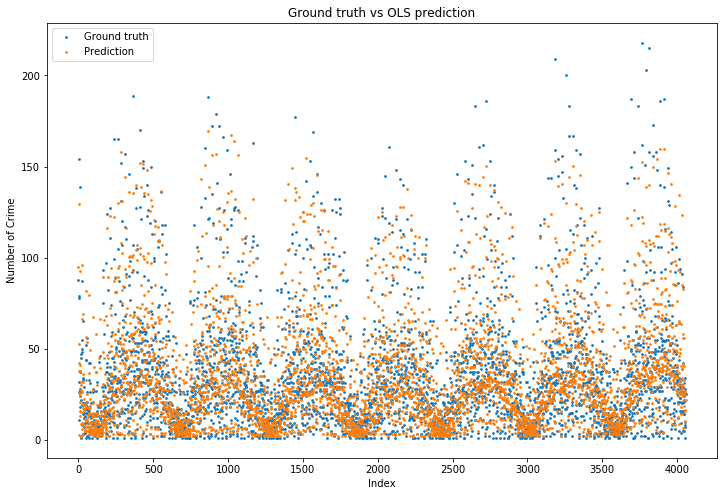

In [28]:
y_pred_NN = model.predict(X_test_final)

# Evaluate model performance
evaluate_prediction(y_test, y_pred_NN)
visualize_prediction(y_test, y_pred_NN)